Nama : Farhan Arif Naufal

Email : opangs82@gmail.com




In [30]:
import os
import warnings
import glob 
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

Download dan Inisiasi Dataset

In [3]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

os.listdir('/tmp/rockpaperscissors/rps-cv-images')


--2021-04-19 05:45:55--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  13.7MB/s    in 18s     

2021-04-19 05:46:14 (17.2 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



['README_rpc-cv-images.txt', 'scissors', 'rock', 'paper']

In [31]:
base_dir = "/tmp/rockpaperscissors/rps-cv-images"
rock_dir = os.path.join(base_dir, 'rock')
paper_dir = os.path.join(base_dir, 'paper')
scissors_dir = os.path.join(base_dir, 'scissors')

In [32]:
# dataset
img_total = len(list(glob.iglob("/tmp/rockpaperscissors/rps-cv-images/*/*.*", recursive=True)))
print("Total Image:",img_total)

# rock
rock_total=len(os.listdir(rock_dir))
# paper
paper_total=len(os.listdir(paper_dir))
# scissors
scissors_total=len(os.listdir(scissors_dir))

# print
print("Rock Image: ",rock_total)
print("Paper Image: ",paper_total)
print("Scissors Image:",scissors_total)

Total Image: 2188
Rock Image:  726
Paper Image:  712
Scissors Image: 750


Validasi

In [33]:
#Validation set 40%
validation_set = 0.4 

Train_datagen = ImageDataGenerator(
    rotation_range = 30,
    brightness_range = [0.2,1.0],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = validation_set
)

Validation_datagen = ImageDataGenerator(
    rotation_range = 30,
    brightness_range = [0.2,1.0],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = validation_set
)

# Validation, train generator categorical 
Train_generator = Train_datagen.flow_from_directory(
    base_dir,
    target_size = (150,150),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 16,
    shuffle = True,
    subset = "training"
)

Validation_generator = Validation_datagen.flow_from_directory(
    base_dir,
    target_size = (150,150),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 16,
    shuffle = False,
    subset = "validation"
)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [34]:
Model = Sequential(
    [
     Conv2D(32, (3,3), strides = (1,1), activation = 'relu', input_shape = (150,150,3)),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Conv2D(64, (3,3), strides = (1,1), activation = 'relu'),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Conv2D(128, (3,3), strides = (1,1), activation = 'relu'),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Flatten(),

     Dropout(0.2),
     Dense(128, activation='relu'),
     Dense(3, activation='softmax')
    ]
)

In [35]:
# Penggunaan Adam Pptimizer Loss Function Category Crossentropy
Adam(learning_rate=0.00146, name='Adam')
Model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [36]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', embeddings_freq=0,
    embeddings_metadata=None
)

Model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 36992)            

Train Model

In [37]:
batch_size = 16

steps_per_epoch = 1314//batch_size
validation_step = 874/batch_size

with tf.device("/device:GPU:0"):
  history = Model.fit(
    Train_generator,
    epochs =  10,
    verbose = 1,
    steps_per_epoch = steps_per_epoch,
    validation_data=Validation_generator,
    validation_steps=validation_step,
    callbacks =[lr_schedule, tb_callback]
    )

Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
82/82 [==============================] - 77s 933ms/step - loss: 1.1563 - accuracy: 0.3793 - val_loss: 0.8291 - val_accuracy: 0.6510
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
82/82 [==============================] - 76s 927ms/step - loss: 0.6567 - accuracy: 0.7413 - val_loss: 0.4709 - val_accuracy: 0.8169
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
82/82 [==============================] - 75s 919ms/step - loss: 0.4126 - accuracy: 0.8578 - val_loss: 0.3798 - val_accuracy: 0.8616
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
82/82 [==============================] - 75s 918ms/step - loss: 0.3799 - accuracy: 0.8499 - val_loss: 0.3164 - val_accuracy: 0.8822
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474

Hasil Prediksi

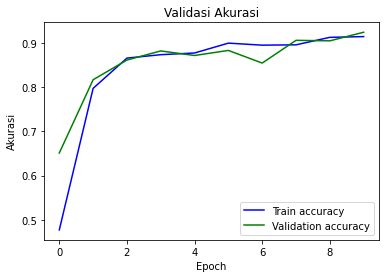

<Figure size 432x288 with 0 Axes>

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Accruracy
plt.plot(epochs, acc, 'b', label='Train accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.title('Validasi Akurasi')
plt.legend(loc=0)
plt.figure()
plt.show()

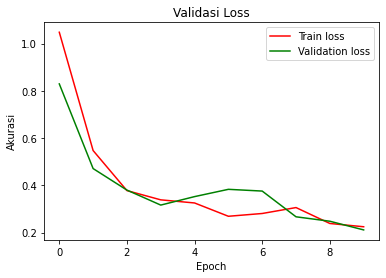

<Figure size 432x288 with 0 Axes>

In [39]:
#Loss
plt.plot(epochs, loss, 'r', label='Train loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.title('Validasi Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

Upload Gambar

Saving 138Tx9KlEfheT3uB.png to 138Tx9KlEfheT3uB.png
Scissors


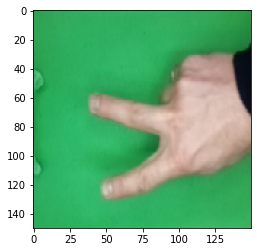

In [41]:
from google.colab import files
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
uploaded = files.upload()

for UUpload in uploaded.keys():
  
  # prediksi gambar
  path = UUpload
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = Model.predict(images, batch_size=16)
  if classes[0][0] == 1:
    print('Paper')
  elif classes[0][1] == 1:
    print('Rock')
  elif classes[0][2] == 1:
    print('Scissors')
  else:
    print('No Result')